# Librerías.

In [1]:
!pip install prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%pylab inline
import pandas as pd
from datetime import datetime
from prophet import Prophet
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import SparkSession
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

Populating the interactive namespace from numpy and matplotlib


# Datos.

In [1]:
def to_list_function(string):
    '''
    esta función convierte un string de una
    lista a una lista
    '''
    return np.array(string.strip('][').replace(r"'","" ).split(', '))

In [2]:
def M_Order(n, DF):
  row = DF['Site Number'][n]
  dates = to_list_function(DF['Date Created'][n])[:-1]
  dates = [str(date) for date in dates]
  moths = [date[::-1].rsplit("/", 1)[0][::-1] for date in dates]
  months, freq = np.unique(moths, return_counts=True)
  fechas = [datetime.strptime(comps, '%m/%Y').date() for comps in months]
  df = pd.DataFrame(columns=['dates', row])
  df[row] = freq
  df['dates'] = fechas
  df = df.set_index('dates')
  df = df.sort_index()

  return df

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Freezers/Data_Time.csv')

# Serie de una tienda con regresores.

El valor a predecir será el número de alarmas en un mes. Para ellos añadiremos como características el número de alarmas en el mes anterior, hace dos meses y hace tres meses.

In [6]:
M_Alarmas = M_Order(1, data)
#Poniendo las fechas como una columna y no un índice.
M_Alarmas = M_Alarmas.reset_index()
#Renombrando las columnas como 'ds' y 'y'.
M_Alarmas.columns = ['ds', 'y']
M_Alarmas.head()

,ds,y
0,2012-02-01,8
1,2012-04-01,4
2,2012-05-01,16
3,2012-06-01,26
4,2012-07-01,35


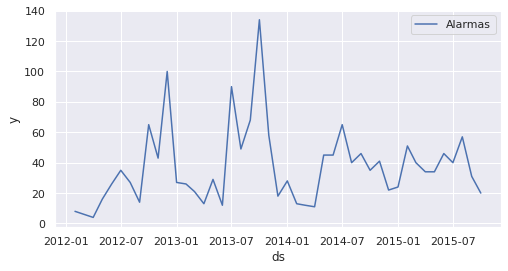

In [7]:
# Visualización.
sns.set(rc={'figure.figsize':(8,4)})
sns.lineplot(x=M_Alarmas.ds, y=M_Alarmas.y)
#sns.lineplot(x=M_Alarmas.ds, y=M_Alarmas.lag_alarmas_1)
plt.legend(['Alarmas'])

In [8]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


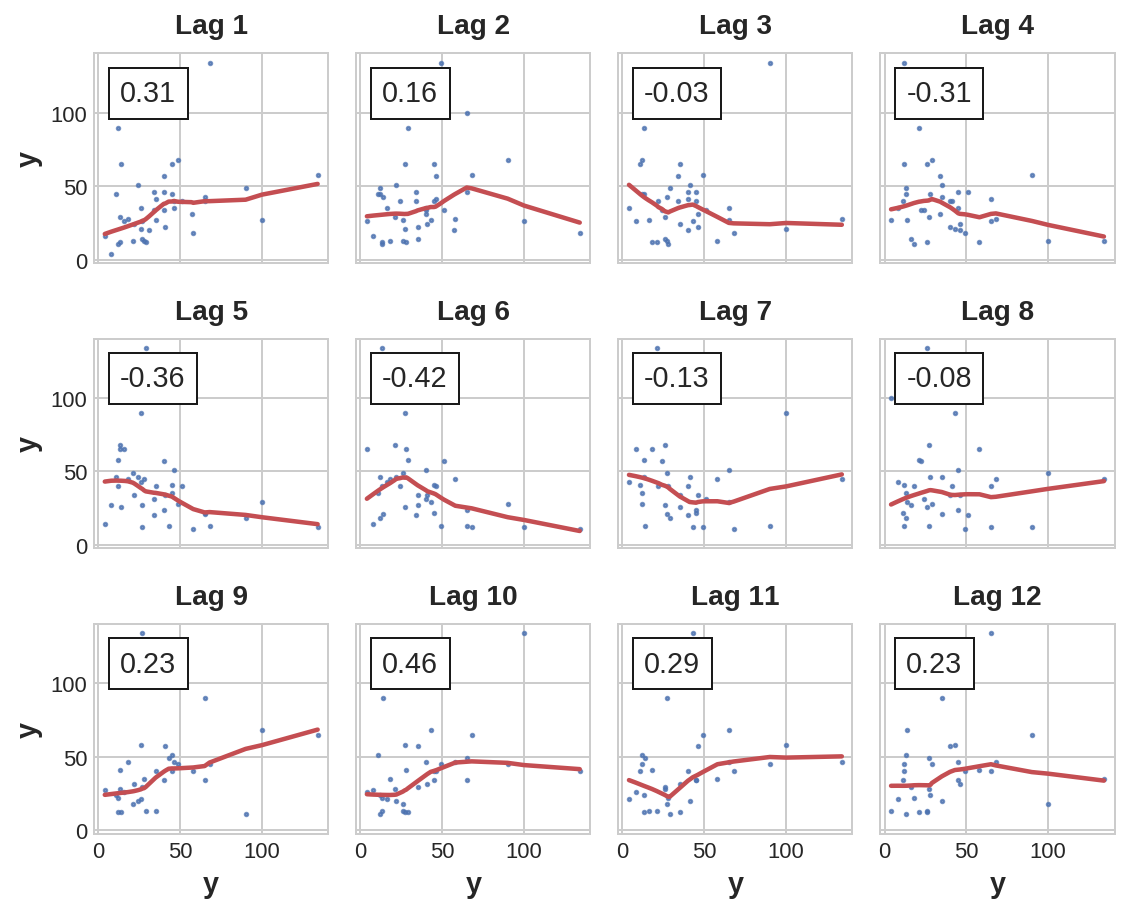

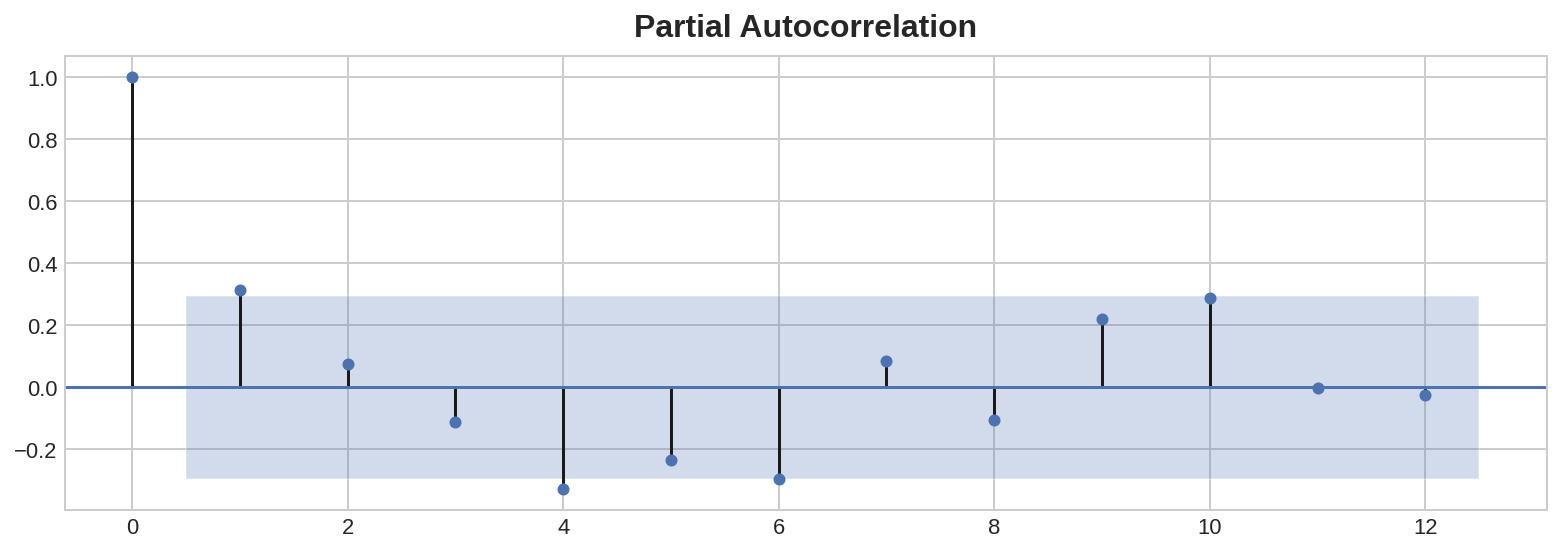

In [9]:
_ = plot_lags(M_Alarmas.y, lags=12, nrows=3)
_ = plot_pacf(M_Alarmas.y, lags=12)

De aquí vemos que el *lag* $9$ es el mejor candidato para la predicción.

In [10]:
def make_lags(ts, lags, df):
  a = df.copy()
  for i in lags:
    a[f'y_lag_{i}'] = ts.shift(i)
  return a

In [11]:
X = make_lags(M_Alarmas.y, [1,4,6], M_Alarmas)
X = X.fillna(0)
X = X.set_index('ds')
X.drop('y', axis=1, inplace=True)
X.head()

,y_lag_1,y_lag_4,y_lag_6
ds,,,
2012-02-01,0.0,0.0,0.0
2012-04-01,8.0,0.0,0.0
2012-05-01,4.0,0.0,0.0
2012-06-01,16.0,0.0,0.0
2012-07-01,26.0,8.0,0.0


In [12]:
M_Alarmas.ds = [i.strftime('%Y-%m-%d') for i in M_Alarmas.ds]

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

In [42]:
# Create target series and data splits
y = M_Alarmas.y.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=11, shuffle=False)

# Fit and predict
model = svm.SVR()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [14]:
fechas = X.index
fechas[-11:]

Index([2014-12-01, 2015-01-01, 2015-02-01, 2015-03-01, 2015-04-01, 2015-05-01,
       2015-06-01, 2015-07-01, 2015-08-01, 2015-09-01, 2015-10-01],
      dtype='object', name='ds')

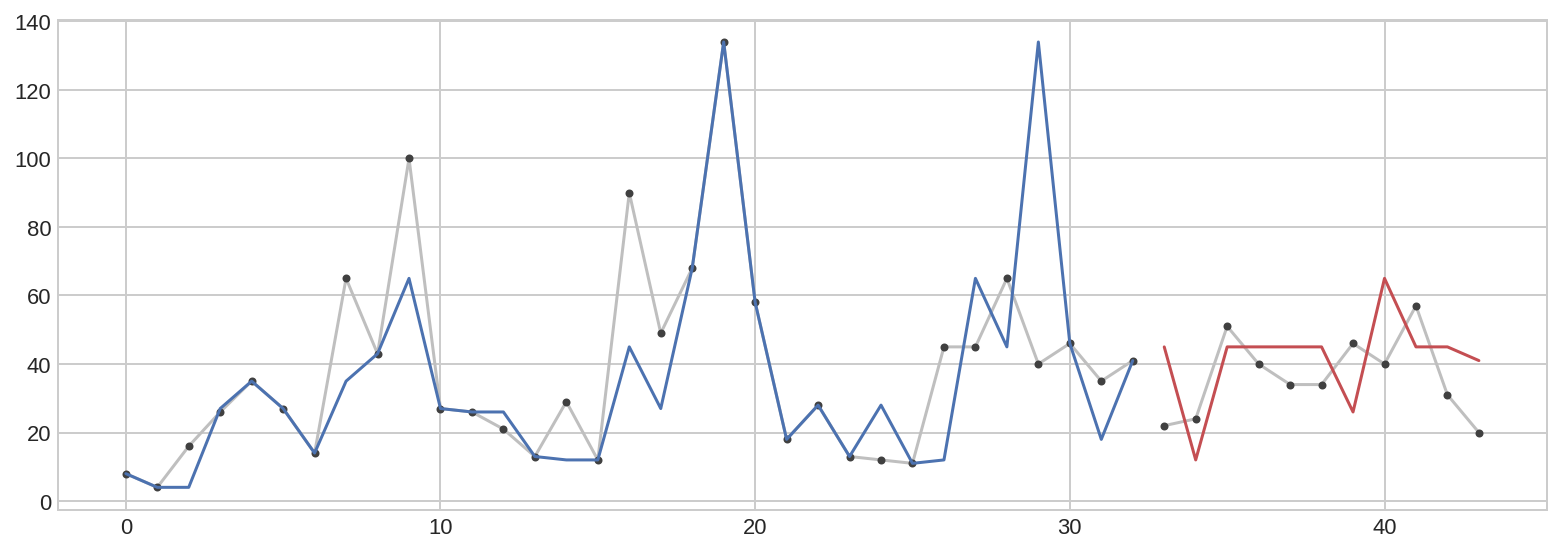

In [27]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

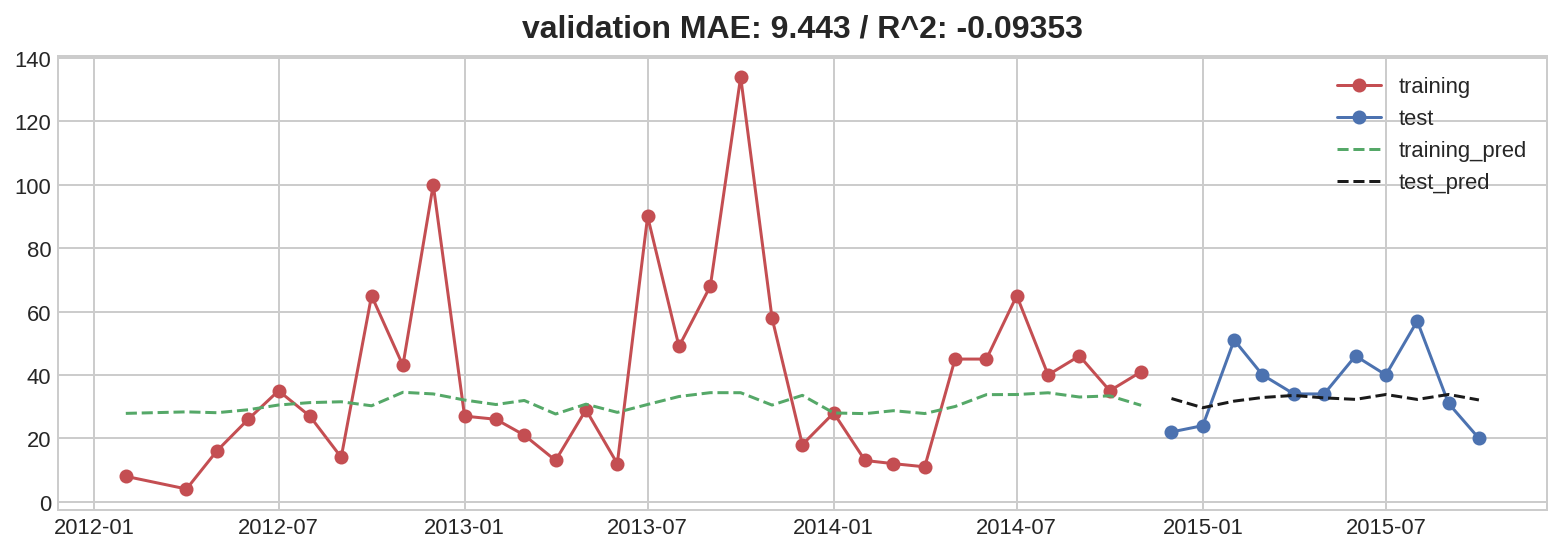

In [43]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_fore)
MAE = np.abs(y_test-y_fore).mean()
plt.title('validation MAE: {:.4} / R^2: {:.4}'.format(MAE, r2))
plt.plot(fechas[:-11], y_train, 'ro-', label='training')
plt.plot(fechas[-11:], y_test, 'bo-', label='test')
plt.plot(fechas[:-11], y_pred, 'g--' , label='training_pred')
plt.plot(fechas[-11:], y_fore, 'k--' , label='test_pred')
plt.legend()

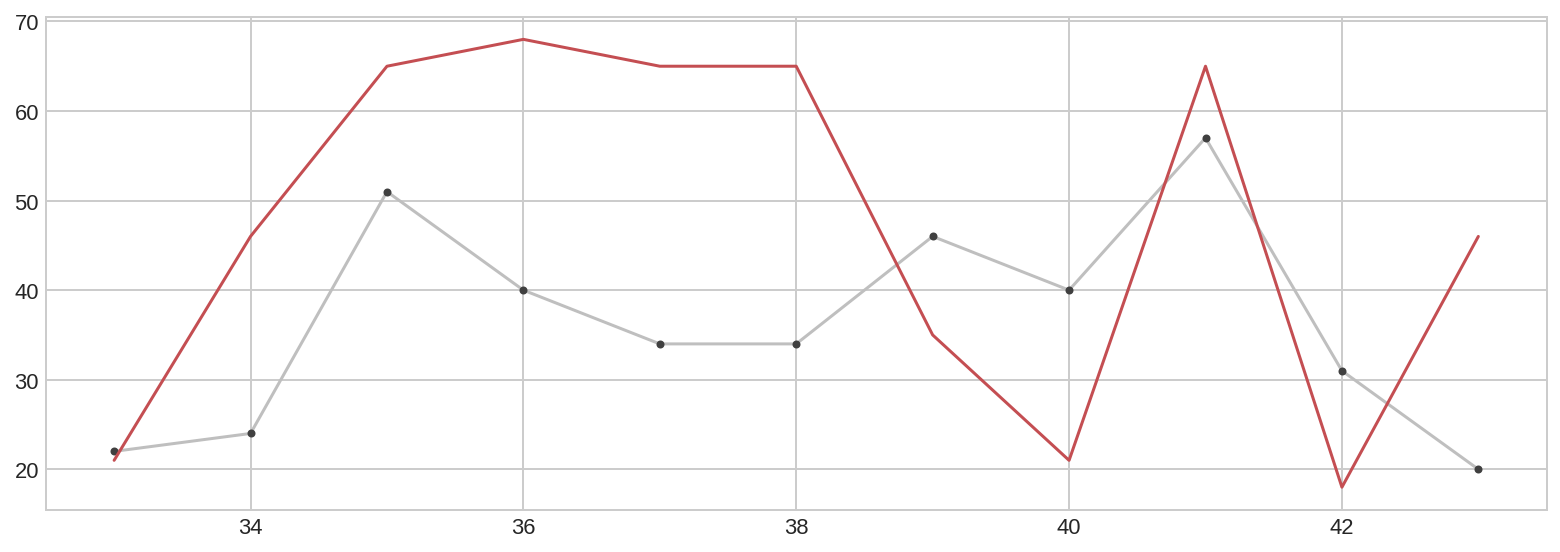

In [35]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

### Split de los datos en *train* y validación.

In [ ]:
train_end_date = datetime.strptime('2015-01-01', '%Y-%m-%d').date()
train = M_Alarmas[M_Alarmas['ds'] < train_end_date]
test = M_Alarmas[M_Alarmas['ds'] >= train_end_date]

### Modelo base.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

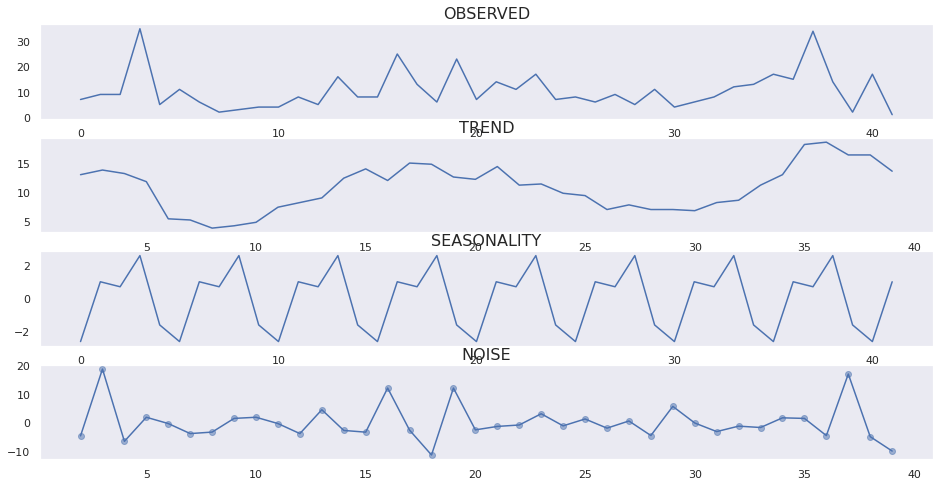

In [ ]:
decompose_bike_sharing_demand(M_Alarmas, share_type='y', samples='all', period=5)

# Predicción.

In [ ]:
type(M_Alarmas['ds'])

pandas.core.series.Series

In [ ]:
M_Alarmas['ds'] = M_Alarmas['ds'].dt.strftime('%Y-%m-%d')

AttributeError: ignored

In [ ]:
lim = 11
train_x, test_x = M_Alarmas.drop(columns='y')[:-lim:], M_Alarmas.drop(columns='y')[-lim:]
train_y, test_y = M_Alarmas['y'][:-lim:], M_Alarmas['y'][-lim:]

In [ ]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

ValueError: ignored